In [16]:
from keras.datasets import imdb
from keras import preprocessing

In [17]:
# Max words to use as features
max_features = 10000

# Max length of review (truncate to this size)
max_length = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print("Number of training samples:", len(x_train))

Number of training samples: 25000


The data is loaded as a list of integers, where x_train[i] is a given review of different length. We'll cut the reviews to only the first 20 words. Shorter reviews will be padded with 0s up to 20 tokens. The following lines will turn a list of integers into a 2D integer tensor of shape (samples, max_length).

In [18]:
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_length)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_length)
print(x_train.shape)

(25000, 20)


In [19]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=max_length))

model.add(Flatten())

# model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 115us/step - loss: 0.6759 - acc: 0.6047 - val_loss: 0.6398 - val_acc: 0.6806
Epoch 2/10
20000/20000 [==============================] - 2s 89us/step - loss: 0.5658 - acc: 0.7428 - val_loss: 0.5467 - val_acc: 0.7208
Epoch 3/10
20000/20000 [==============================] - 2s 83us/step - loss: 0.4752 - acc: 0.7808 - val_loss: 0.5113 - val_acc: 0.7380
Epoch 4/10
20000/20000 [==============================] - 2s 76us/step - loss: 0.4264 - acc: 0.8077 - val_loss: 0.5008 - val_acc: 0.7452
Epoch 5/10
20000/20000 [==============================] - 2s 76us/step - loss: 0.3931 - acc: 0.8256 - val_loss: 0.4981 - val_acc: 0.7542
Epoch 6/10
20000/20000 [==============================] - 2s 76us/step - loss: 0.3669 - acc: 0.8397 - val_loss: 0.5013 - val_acc: 0.7536
Epoch 7/10
20000/20000 [==============================] - 2s 78us/step - loss: 0.3436 - acc: 0.8533 - val_loss: 0.5051 - val_acc

In [21]:
# I think this is how you can access the embeddings..
emb = model.layers[0]
weights = emb.get_weights()
weights[0][0]

array([-0.11529426,  0.00810136, -0.04695838,  0.07720837, -0.05905389,
        0.04915098,  0.08293566, -0.0496396 ], dtype=float32)

## Using pretrained word embeddings

In this case we'll use the raw data of the IMDB dataset, not the one included in the Keras module.

In [22]:
import os

imdb_dir = '/Users/Misko/PycharmProjects/Playfield/data/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Max review length
maxlen =  100
# Use a small training dataset, since we're using pretrained embeddings
training_samples = 200
validation_samples = 10000
# Use only the top 10000 words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

# Convert strings to integer indices
sequences = tokenizer.texts_to_sequences(texts)

# word_index will contain all the unique words in the text, ranked by appearance
word_index = tokenizer.word_index
print("Found %d unique tokens." % len(word_index))

Found 88582 unique tokens.


In [24]:
# Cutoff to a `maxlen` length of review
# It seems that in case a sequence is longer than maxlen, the `pad_sequences` method will keep the last 
# maxlen tokens and drop the rest at the start of the sequence. 
# It might be better to do it the other way around?
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Randomly shuffle the samples and corresponding labels
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


We can now use the GloVe embeddings, which were previously downloaded from this [link](https://nlp.stanford.edu/projects/glove/). We'll use the GloVe embeddings using 100 dimensions ie., each word (of the 400000 ones) will be encoded in a 100D vector.

In [25]:
glove_dir = '/Users/Misko/PycharmProjects/Playfield/data/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [26]:
word_index.pop('an')

32

In [30]:
embedding_dim = 100  # as in downloaded data

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    # more frequent words have smaller index in `word_index`
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector        

We can next define the model. The GloVe embeddings will be plugged in the Embedding layer. 

In [31]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Now, initialise the Embedding layer with the GloVe vectors of the 10000 most frequent words.

In [34]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [35]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10, 
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 1.8161 - acc: 0.4950 - val_loss: 0.7421 - val_acc: 0.5168
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5176 - acc: 0.7350 - val_loss: 0.7286 - val_acc: 0.5365
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3688 - acc: 0.8550 - val_loss: 0.6977 - val_acc: 0.5649
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3849 - acc: 0.8600 - val_loss: 0.7898 - val_acc: 0.5347
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2685 - acc: 0.8900 - val_loss: 0.6949 - val_acc: 0.5822
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1375 - acc: 0.9650 - val_loss: 1.6232 - val_acc: 0.5084
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3206 - acc: 0.8400 - val_loss: 0.7300 - val_acc: 0.5628
Epoch 8/10
200/200 [========

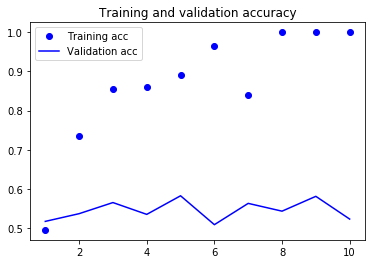

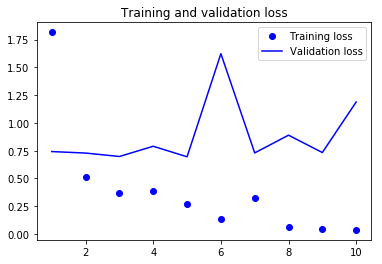

In [38]:
def plot_history(history):
    
    import matplotlib.pyplot as plt
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history)

The model quickly starts overfitting, because of the small number of training samples. It seems that the training samples were really too few. We can later check with a bigger training set, but first let's see the performance of using self-trained embeddings on the same training dataset of only 200 samples.

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6941 - acc: 0.4950 - val_loss: 0.6955 - val_acc: 0.5178
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5001 - a

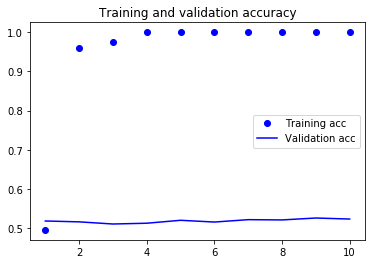

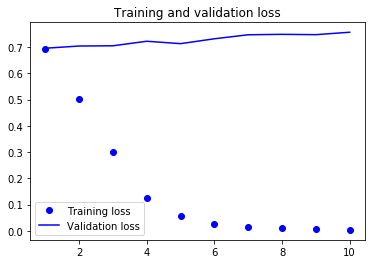

In [40]:
plot_history(history)

Let's go to testing now!

In [44]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['pos', 'neg']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen)
y_test = np.asarray(labels)

In [45]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 65us/step


[1.2143886346626283, 0.51368]